In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score

import pandas as pd
import numpy as np
import nltk

import tensorflow as tf
import re
import random
import spacy

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, callbacks, optimizers
from transformers import DistilBertTokenizerFast, TFDistilBertModel

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

/home/tomy07417/data-science/ml/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [62]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [63]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

X_train, X_val, y_train, y_val = train_test_split(
    train['text'], train['target'], test_size=0.2, random_state=SEED
)

In [83]:
MAX_LEN = 50
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

enc_train = tokenizer(
    X_train.tolist(),
    max_length=50,
    truncation=True,
    padding="max_length",
    return_tensors="tf"
)

input_ids_train = enc_train["input_ids"]
attention_mask_train = enc_train["attention_mask"]


enc_val = tokenizer(
    X_val.tolist(),
    max_length=50,
    truncation=True,
    padding="max_length",
    return_tensors="tf"
)

input_ids_val = enc_val["input_ids"]
attention_mask_val = enc_val["attention_mask"]

In [84]:
class DistilBertLayer(tf.keras.layers.Layer):
    def __init__(self, model_name="distilbert-base-uncased"):
        super().__init__()
        self.bert = TFDistilBertModel.from_pretrained(model_name, from_pt=True)

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            training=False
        )
        return outputs.last_hidden_state

In [ ]:
inputs_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')

bert_outputs = DistilBertLayer()([inputs_ids, attention_mask])

gru = layers.Bidirectional(
    layers.GRU(128, return_sequences=False, dropout=0.3)
)(bert_outputs)
drop2 = layers.Dropout(0.3)(gru)

dense = layers.Dense(64, activation='relu')(drop2)
drop3 = layers.Dropout(0.2)(dense)

output = layers.Dense(1, activation='sigmoid')(drop3)

model = models.Model(inputs=[inputs_ids, attention_mask], outputs=output)

model.compile(optimizer=optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopper = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.001)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Some weights of the PyTorch model were not used w

In [86]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_layer_1 │ (None, 50, 768)   │          0 │ input_ids[0][0],  │
│ (DistilBertLayer)   │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 256)       │    689,664 │ distil_bert_laye… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 256)       │          0 │ bidirectional_7[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │     16,448 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64)        │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │         65 │ dropout_16[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 706,177 (2.69 MB)

 Trainable params: 706,177 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

In [87]:
hist = model.fit([input_ids_train, attention_mask_train], y_train, epochs=30, validation_data=([input_ids_val, attention_mask_val], y_val), callbacks=[early_stopper], batch_size=64)

Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.6662 - loss: 0.6130 - val_accuracy: 0.7879 - val_loss: 0.4975
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.7658 - loss: 0.5055 - val_accuracy: 0.8135 - val_loss: 0.4448
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 95s 993ms/step - accuracy: 0.7895 - loss: 0.4683 - val_accuracy: 0.8135 - val_loss: 0.4322
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.7972 - loss: 0.4497 - val_accuracy: 0.8162 - val_loss: 0.4246
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 94s 979ms/step - accuracy: 0.8053 - loss: 0.4353 - val_accuracy: 0.8194 - val_loss: 0.4185
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.8095 - loss: 0.4254 - val_accuracy: 0.8188 - val_loss: 0.4153
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.8123 - loss: 0.4154 - val_accuracy: 0.8194 - val_loss: 0.4106
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.8200 - loss: 0.4069 - val_accuracy: 0.8201

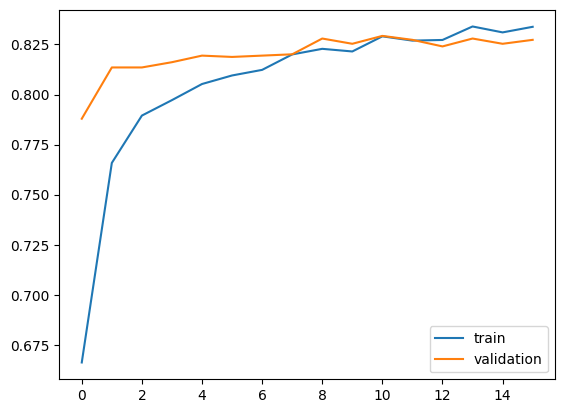

In [88]:
acc = hist.history['accuracy']
acc_val = hist.history['val_accuracy']
plt.plot(acc, label='train')
plt.plot(acc_val, label='validation')
plt.legend()
plt.show()

In [89]:
y_pred = (model.predict([input_ids_val, attention_mask_val]) > 0.5).astype(int)
f1 = f1_score(y_val, y_pred)
print("F1 Score:", f1)

48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 415ms/step
F1 Score: 0.7833333333333333


In [ ]:
enc_text = tokenizer(
    test['text'].tolist(),
    max_length=50,
    truncation=True,
    padding="max_length",
    return_tensors="tf"
)

input_ids_test = enc_text["input_ids"]
attention_mask_test = enc_text["attention_mask"]

y_pred_test = (model.predict([input_ids_test, attention_mask_test]) > 0.5).astype(int)
submission = pd.DataFrame({
    'id': test['id'],
    'target': y_pred_test.flatten()
})
submission.to_csv('submission/neural_network_v2_submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 42s 412ms/step
